# Tarea 2
Automata finito determinista para analizador lexico con expresiones regulares.

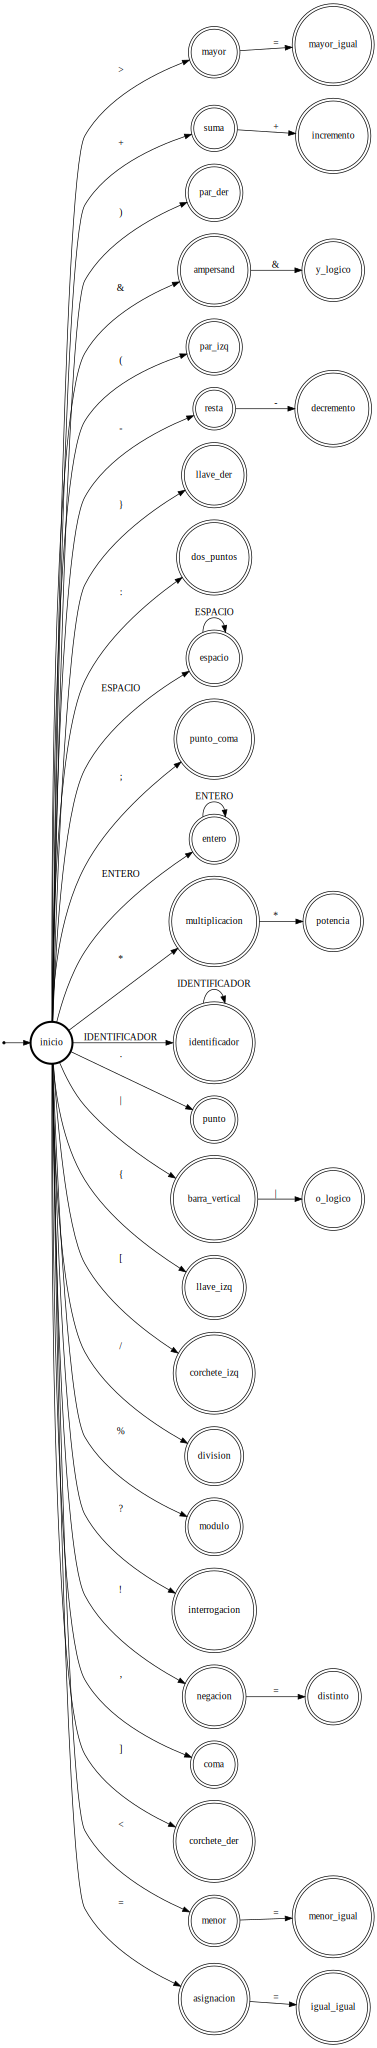

In [56]:

# Analizador léxico con AFD + ER


from dataclasses import dataclass
from typing import Dict, Set, List, Tuple, Optional
import re
from IPython.display import display, HTML
import graphviz


# Clase DFA

@dataclass
class DFA:
    states: Set[str]
    alphabet: Set[str]
    transition: Dict[Tuple[str, str], str]
    start_state: str
    accept_states: Set[str]

    def step(self, state: str, symbol: str) -> str:
        key = (state, symbol)
        if key not in self.transition:
            raise ValueError(f"No hay transición definida para ({state}, {repr(symbol)})")
        return self.transition[key]

    def simulate(self, input_symbols: List[str]):
        current = self.start_state
        log = []
        for i, sym in enumerate(input_symbols):
            if sym not in self.alphabet and (current, sym) not in self.transition:
                raise ValueError(f"Símbolo inválido: {repr(sym)}. Alfabeto: {sorted(self.alphabet)}")
            if (current, sym) not in self.transition:
                raise ValueError(f"No hay transición definida para ({current}, {repr(sym)})")
            nxt = self.step(current, sym)
            log.append((i, current, sym, nxt))
            current = nxt
        return current, log

    def accepts(self, input_symbols: List[str]) -> bool:
        final, _ = self.simulate(input_symbols)
        return final in self.accept_states




def draw_dfa(dfa: DFA, highlight_path: Optional[List[Tuple[str, str, str]]] = None,
             highlight_state: Optional[str] = None):

    dot = graphviz.Digraph(format="png")
    dot.attr(rankdir="LR")
    dot.node("", shape="point")  # flecha de inicio

    # Estados (doble círculo para estados de aceptación)
    for s in dfa.states:
        shape = "doublecircle" if s in dfa.accept_states else "circle"
        penwidth = "3" if highlight_state == s else "1"
        dot.node(s, shape=shape, penwidth=penwidth)

    dot.edge("", dfa.start_state)  # inicio

    # Agrupar aristas por (src, dst) para unir etiquetas
    edges_labels = {}
    for (src, sym), dst in dfa.transition.items():
        edges_labels.setdefault((src, dst), []).append(sym)

    highlighted_pairs = set((src, dst) for (src, sym, dst) in (highlight_path or []))

    for (src, dst), syms in edges_labels.items():
        label = ", ".join(sorted(syms))
        if (src, dst) in highlighted_pairs:
            dot.edge(src, dst, label=label, color="blue", penwidth="2")
        else:
            dot.edge(src, dst, label=label)

    return dot


def steps_table(log):
    """Muestra una tabla HTML simple con el log de pasos."""
    if not log:
        display(HTML("<em>No hubo transiciones (entrada vacía).</em>"))
        return
    rows = ["<tr><th>#</th><th>Estado actual</th><th>Símbolo</th><th>Próximo estado</th></tr>"]
    for i, s, sym, nxt in log:
        rows.append(f"<tr><td>{i}</td><td>{s}</td><td>{sym}</td><td>{nxt}</td></tr>")
    html = "<table>" + "".join(rows) + "</table>"
    display(HTML(html))

# estados
estados = {
    "inicio",

    # categorías básicas
    "identificador",     # [a-zA-Z_][a-zA-Z0-9_]*
    "entero",            # [0-9]+
    "espacio",           # ignora

    # operadores aritméticos
    "suma",              # +
    "resta",             # -
    "multiplicacion",    # *
    "potencia",          # ** (elevado)
    "division",          # /
    "modulo",            # %

    # incremento / decremento
    "incremento",        # ++
    "decremento",        # --

    # asignación / igualdad
    "asignacion",        # =
    "igual_igual",       # ==

    # relacionales
    "menor",             # <
    "menor_igual",       # <=
    "mayor",             # >
    "mayor_igual",       # >=
    "negacion",          # !
    "distinto",          # !=

    # lógicos
    "ampersand",         # &
    "y_logico",          # &&
    "barra_vertical",    # |
    "o_logico",          # ||

    # ternario
    "interrogacion",     # ?
    "dos_puntos",        # :

    # signos de puntuación
    "par_izq", "par_der",           # ( )
    "llave_izq", "llave_der",       # { }
    "corchete_izq", "corchete_der", # [ ]
    "punto_coma", "coma", "punto",  # ; , .
}

# Estados de aceptación (cada token es su propio estado aceptado)
estados_aceptacion = {
    "identificador", "entero", "espacio",

    "suma", "resta", "multiplicacion", "potencia", "division", "modulo",
    "incremento", "decremento",

    "asignacion", "igual_igual",
    "menor", "menor_igual", "mayor", "mayor_igual", "negacion", "distinto",

    "ampersand", "y_logico", "barra_vertical", "o_logico",

    "interrogacion", "dos_puntos",

    "par_izq", "par_der", "llave_izq", "llave_der", "corchete_izq", "corchete_der",
    "punto_coma", "coma", "punto",
}

# alfabeto

alfabeto = {"+", "-", "*", "/", "%", "=", "<", ">", "!", "&", "|", "?", ":", "(", ")", "{", "}", "[", "]", ";", ",", "."}

# Transiciones
transiciones = {
    # operadores aritméticos y variantes
    ("inicio", "+"): "suma",
    ("inicio", "-"): "resta",
    ("inicio", "*"): "multiplicacion",
    ("inicio", "/"): "division",
    ("inicio", "%"): "modulo",

    # asignación / igualdad
    ("inicio", "="): "asignacion",

    # relacionales
    ("inicio", "<"): "menor",
    ("inicio", ">"): "mayor",
    ("inicio", "!"): "negacion",

    # lógicos
    ("inicio", "&"): "ampersand",
    ("inicio", "|"): "barra_vertical",

    # ternario
    ("inicio", "?"): "interrogacion",
    ("inicio", ":"): "dos_puntos",

    # signos de puntuación
    ("inicio", "("): "par_izq",
    ("inicio", ")"): "par_der",
    ("inicio", "{"): "llave_izq",
    ("inicio", "}"): "llave_der",
    ("inicio", "["): "corchete_izq",
    ("inicio", "]"): "corchete_der",
    ("inicio", ";"): "punto_coma",
    ("inicio", ","): "coma",
    ("inicio", "."): "punto",

    # categorías por ER (clases léxicas)
    ("inicio", "IDENTIFICADOR"): "identificador",
    ("inicio", "ENTERO"): "entero",
    ("inicio", "ESPACIO"): "espacio",

    # bucles de construcción de lexemas
    ("identificador", "IDENTIFICADOR"): "identificador",
    ("entero", "ENTERO"): "entero",
    ("espacio", "ESPACIO"): "espacio",

    # concatenaciones / promociones (maximal munch)
    ("multiplicacion", "*"): "potencia",     # **
    ("asignacion", "="): "igual_igual",      # ==
    ("menor", "="): "menor_igual",           # <=
    ("mayor", "="): "mayor_igual",           # >=
    ("negacion", "="): "distinto",           # !=
    ("ampersand", "&"): "y_logico",          # &&
    ("barra_vertical", "|"): "o_logico",     # ||
    ("suma", "+"): "incremento",             # ++
    ("resta", "-"): "decremento",            # --
}

# Ensamblar AFD
lexer_dfa = DFA(
    states=estados,
    alphabet=alfabeto,
    transition=transiciones,
    start_state="inicio",
    accept_states=estados_aceptacion
)

seq1 = []
final1, log1 = lexer_dfa.simulate(seq1)

#log1=[]
steps_table(log1)
display(draw_dfa(lexer_dfa, highlight_path=[(s, sym, nxt) for (_, s, sym, nxt) in log1],
                  highlight_state=final1))


In [57]:

# Palabras reservadas
PALABRAS_RESERVADAS = {
    "if", "else", "while", "for", "return", "int", "float", "void", "true", "false"
}

def reclasificar_identificador(lexema: str) -> str:
    return "PALABRA_RESERVADA" if lexema in PALABRAS_RESERVADAS else "identificador"

# ER
patrones = {
    "IDENTIFICADOR": r"^[A-Za-z_][A-Za-z0-9_]*$",
    "ENTERO":        r"^[0-9]+$",

    # Operadores
    "ARITMETICO":    r"^(\+|-|/|\*{1,2}|%)$",
    "INCREMENTO":    r"^\+\+$",
    "DECREMENTO":    r"^--$",

    "ASIGNACION":    r"^=$",
    "IGUAL_IGUAL":   r"^==$",

    "RELACIONAL":    r"^(<=|>=|==|!=|<|>)$",
    "LOGICO":        r"^(&&|\|\||!|&|\|)$",

    # Ternario
    "INTERROGACION": r"^\?$",
    "DOS_PUNTOS":    r"^:$",

    # Puntuación
    "PUNTUACION":    r"^[\(\)\{\}\[\];,\.]$",

    # Espacios
    "ESPACIO":       r"^[ \t\n]+$",
}

def analizar_token(token):
    """
    Función que clasifica un token según los patrones definidos.
    """
    for tipo, patron in patrones.items():
        if re.match(patron, token):
            return tipo
    return "inválido"
# evaluar caracter a caracter
def tokenizar(cadena: str) -> List[Tuple[str, str]]:
    tokens: List[Tuple[str, str]] = []
    i = 0
    n = len(cadena)

    while i < n:
        estado = lexer_dfa.start_state
        j = i
        ultimo_acept = None
        pos_ultimo_acept = None

        while j < n:
            c = cadena[j]
            tipo = analizar_token(c)
            if tipo == "IDENTIFICADOR" or tipo == "ENTERO" or tipo == "ESPACIO":
              c = tipo
            key = (estado, c)
            if key not in lexer_dfa.transition:

                #print("break", key)
                break
            estado = lexer_dfa.transition[key]
            if estado in lexer_dfa.accept_states:
                ultimo_acept = estado
                pos_ultimo_acept = j + 1
            j += 1

        if ultimo_acept is None:
            raise ValueError(f"Error léxico en {i}: {repr(cadena[i])}")

        lexema = cadena[i:pos_ultimo_acept]
        #print(lexema)
        # Ignorar espacios
        if ultimo_acept != "espacio":
            tipo = ultimo_acept
            # Reclasificar identificadores que sean palabras reservadas
            if ultimo_acept == "identificador":
                tipo = reclasificar_identificador(lexema)
            tokens.append((tipo, lexema))

        i = pos_ultimo_acept

    return tokens

# cadenas y prueba

pruebas = [
    "x=2**2+22+ 300 ",
      "y== 20/233",
    "suma=1+300",
    "x =/ 20++3",
    "if(x>=10&&y!=20){x=x**2;}",
    "contador++ --valor",
    "a?b:c",
    "if (10)",
    "[i]=arr[i]%2;",
    "obj.propiedad",
]

for s in pruebas:
    print(f"\nEntrada: {s}")
    try:
        toks = tokenizar(s)
        for t in toks:
            print("->", t)
    except ValueError as e:
        print("  ERROR:", e)



Entrada: x=2**2+22+ 300 
-> ('identificador', 'x')
-> ('asignacion', '=')
-> ('entero', '2')
-> ('potencia', '**')
-> ('entero', '2')
-> ('suma', '+')
-> ('entero', '22')
-> ('suma', '+')
-> ('entero', '300')

Entrada: y== 20/233
-> ('identificador', 'y')
-> ('igual_igual', '==')
-> ('entero', '20')
-> ('division', '/')
-> ('entero', '233')

Entrada: suma=1+300
-> ('identificador', 'suma')
-> ('asignacion', '=')
-> ('entero', '1')
-> ('suma', '+')
-> ('entero', '300')

Entrada: x =/ 20++3
-> ('identificador', 'x')
-> ('asignacion', '=')
-> ('division', '/')
-> ('entero', '20')
-> ('incremento', '++')
-> ('entero', '3')

Entrada: if(x>=10&&y!=20){x=x**2;}
-> ('PALABRA_RESERVADA', 'if')
-> ('par_izq', '(')
-> ('identificador', 'x')
-> ('mayor_igual', '>=')
-> ('entero', '10')
-> ('y_logico', '&&')
-> ('identificador', 'y')
-> ('distinto', '!=')
-> ('entero', '20')
-> ('par_der', ')')
-> ('llave_izq', '{')
-> ('identificador', 'x')
-> ('asignacion', '=')
-> ('identificador', 'x')
-> ('po

In [58]:

# Interfaz de usuario
from google.colab import files
print("Este programa es un analizador léxico, escribe algún input para probarlo")
cadena = input("Escribe aquí (ej: if(true) ): ")
print(cadena)

print(f"\nEntrada: {cadena}")
try:
    toks = tokenizar(cadena)
    for t in toks:
        print("->", t)
    csv_filename = "tokens.txt"
    # Guardar tokens en un archivo
    with open(csv_filename, "w", encoding="utf-8") as f:
        f.write(f"Entrada: {cadena}\n")
        for t in toks:
            f.write(f"{t}\n")   # escribe cada token en una línea

    files.download(csv_filename)
    print("\n✅ Tokens guardados en 'tokens.txt'")

except ValueError as e:
    print("  ERROR:", e)


Este programa es un analizador léxico, escribe algún input para probarlo
Escribe aquí (ej: if(true) ): if(3+3||true)
if(3+3||true)

Entrada: if(3+3||true)
-> ('PALABRA_RESERVADA', 'if')
-> ('par_izq', '(')
-> ('entero', '3')
-> ('suma', '+')
-> ('entero', '3')
-> ('o_logico', '||')
-> ('PALABRA_RESERVADA', 'true')
-> ('par_der', ')')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Tokens guardados en 'tokens.txt'
